In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#to display the graph in the same window itself
#%matplotlib.inline
#defining the size of window
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=10,6

In [178]:
dataset=pd.read_csv('AirPassengers.csv')
dataset['Month']=pd.to_datetime(dataset['Month'],infer_datetime_format=True)
indexed_dataset=dataset.set_index(['Month'])

In [179]:
dataset.head(5)

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [180]:
indexed_dataset.head(5)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


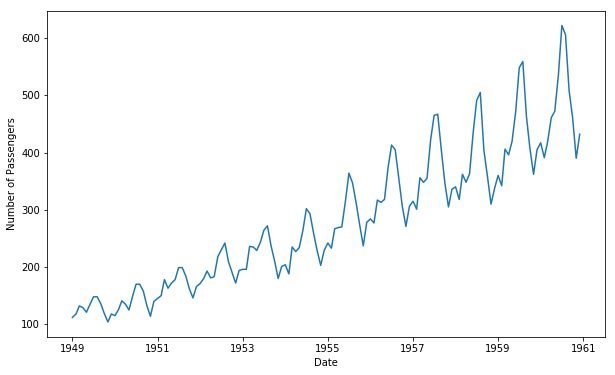

In [182]:
#plot graph
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.plot(indexed_dataset)
plt.show()

In [183]:
#Determining Rolling Statistics

#rolling mean
rolmean=indexed_dataset.rolling(window=12).mean()
#rolling standard deviation
rolstd=indexed_dataset.rolling(window=12).std()

#print(rolmean,rolstd)

In [184]:
#Two ways to test the stationarity of Data
from statsmodels.tsa.stattools import adfuller 
def test_stationarity(timeseries):
    #1.plotting rolling statistics:-Mean and variance should remain same over the moving windows
    
    #Determining Rolling Statistics

    #rolling mean
    rolmean=timeseries.rolling(window=12).mean()
    #rolling standard deviation
    rolstd=timeseries.rolling(window=12).std()
    
    org=plt.plot(timeseries,color='blue',label='Original')
    mean=plt.plot(rolmean,color='red',label='Rolling Mean')
    std=plt.plot(rolstd,color='black',label='Rolling Standard Deviation')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Rolling Deviation')
    plt.show()

    #2.Dickey Fuller Test - NULL Hypothesis which says the data is non-stationary, if test statistics is less than critical value,
    #NULL Hypothesis is rejected, Rejection of NULL Hypothesis is an indication of stationary data
    # AIC :- Akaike's information criterion which gives information between exact value and calculated value
    
    print('Results of ADCF(Augmented Dickey Fuller Test)')
    dftest=adfuller(timeseries['#Passengers'],autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],index=['Test-Statistics','p-value','Lags-used','Number of Observations used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key]=value
    print(dfoutput)
    
    
    




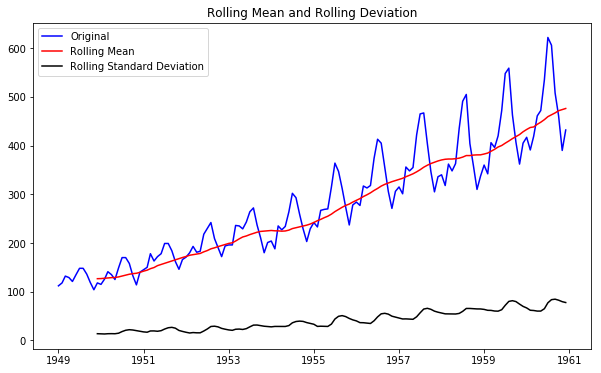

Results of ADCF(Augmented Dickey Fuller Test)
Test-Statistics                  0.815369
p-value                          0.991880
Lags-used                       13.000000
Number of Observations used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64


In [185]:
indexed_dataset.dropna(inplace=True)
test_stationarity(indexed_dataset)

In [186]:
#Non- Sationarity is clearly visible from Rolling Statistics,also from dickey fuller test since test statistics is greater than
#critical value, NULL Hypthesis is not rejected 
#so it needs to be converted to stationary so that AR,MA and ARIMA model can be applied to it

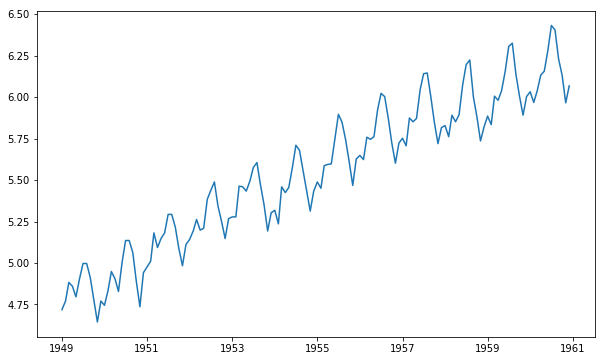

In [187]:
#1st Transformation : - Taking Log of the dataset
logged_dataset=np.log(indexed_dataset)
plt.plot(logged_dataset)
plt.show()

In [188]:
#2nd Transformation : - Subtracting Moving Average from the dataset

moving_average=logged_dataset.rolling(window=12).mean()
logged_datasetMINUSmoving_average=logged_dataset-moving_average
logged_datasetMINUSmoving_average.head(12)
logged_datasetMINUSmoving_average.dropna(inplace=True)
logged_datasetMINUSmoving_average.head(12)

,#Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142
1950-05-01,-0.027529
1950-06-01,0.139881
1950-07-01,0.260184
1950-08-01,0.248635


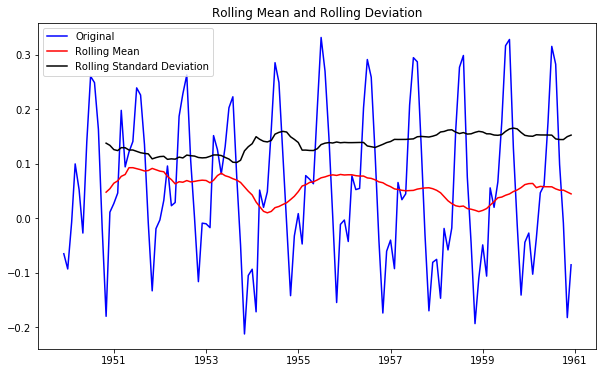

Results of ADCF(Augmented Dickey Fuller Test)
Test-Statistics                 -3.162908
p-value                          0.022235
Lags-used                       13.000000
Number of Observations used    119.000000
Critical Value (5%)             -2.886151
Critical Value (1%)             -3.486535
Critical Value (10%)            -2.579896
dtype: float64


In [189]:
test_stationarity(logged_datasetMINUSmoving_average)

In [190]:
#Now the data looks somewhat stationary
#Using shift function :- Shifts the data by 1
temp=logged_dataset.shift()
temp.head(10)

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,4.718499
1949-03-01,4.770685
1949-04-01,4.882802
1949-05-01,4.859812
1949-06-01,4.795791
1949-07-01,4.905275
1949-08-01,4.997212
1949-09-01,4.997212


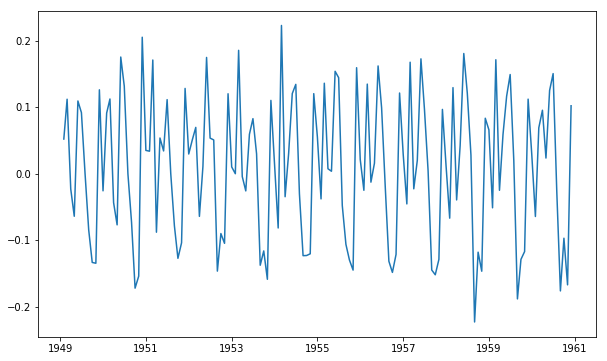

In [193]:
loggedShifted_dataset=logged_dataset-temp
loggedShifted_dataset.dropna(inplace=True)
plt.plot(loggedShifted_dataset)
plt.show()

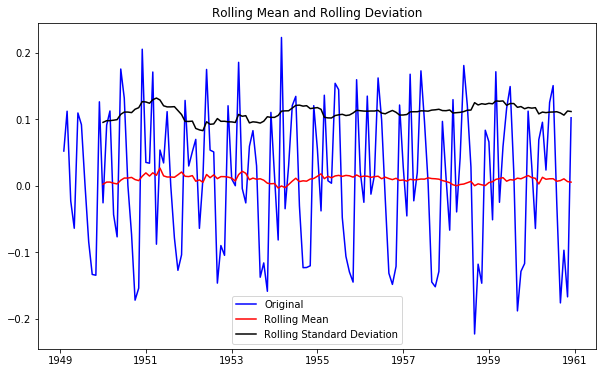

Results of ADCF(Augmented Dickey Fuller Test)
Test-Statistics                 -2.717131
p-value                          0.071121
Lags-used                       14.000000
Number of Observations used    128.000000
Critical Value (5%)             -2.884398
Critical Value (1%)             -3.482501
Critical Value (10%)            -2.578960
dtype: float64


In [194]:
test_stationarity(loggedShifted_dataset)
#This gives the stationary dataset

In [195]:

#ACF : - AutoCorrelation Function, shows relation between time t and all previous intervals
#PACF : - Partial AutoCorrelation Function, shows relation between time t and previous interval
#Example if stress level in office is very high on monday, so there will be a pattern after every seven days,so stress level on
#monday is highly correlated with stress level seven days ago, 14 days ago and so on. PACF shows just the correlation with last 
#week while ACF shows it all over

#PACF is used to calculate AR(Auoto Regression):
#AR :  X(t)=a*X(t-1)+b*X(t-2)+ Error.......
#P is the order of AR which is used as a first parameter in ARIMA Model.

#ACF is used to calculate MA(Moving Average)
#Moving Average : X(t)=a*E1(t-1)+b*E2(t-2)+...(Here, E1,E2 etc..are the error terms)
#Q is the order of MA which is used as a third parameter in ARIMA Model.

#I in ARIMA model is used as a second parameter which is Integration or Differencing
#Since, we have shifted the values by 1 in the above example, I is 1 here



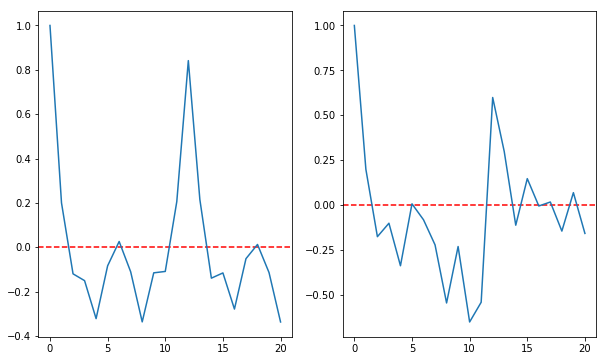

In [196]:
#Now let's Draw ACF and PACF Graph

from statsmodels.tsa.stattools import acf,pacf
#plot_acf
plt.subplot(121)
log_acf=acf(loggedShifted_dataset,nlags=20)
plt.axhline(y=0,linestyle='--',color='red')
plt.plot(log_acf)
#plot_pacf
plt.subplot(122)
#ols : ordinary least square method
log_pacf=pacf(loggedShifted_dataset,nlags=20,method='ols')
plt.axhline(y=0,linestyle='--',color='red')
plt.plot(log_pacf)

plt.show()

In [197]:
#Inorder to calucate P and Q values from ACF and PACF, we need to check when y value drops to zero for the first time
#Here P=Q=2

C:\Users\Adarsh\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\Adarsh\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\Adarsh\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Adarsh\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float`

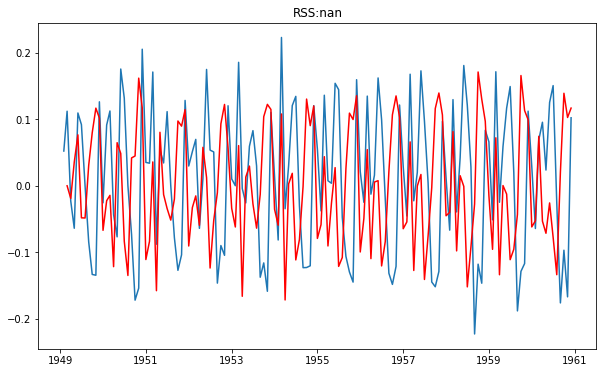

In [198]:
#ARIMA_MODEL

from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(loggedShifted_dataset,order=(2,1,2))
results_ARIMA=model.fit()
plt.plot(loggedShifted_dataset)
plt.plot(results_ARIMA.fittedvalues,color='red')
plt.title('RSS:%.4f'%sum((results_ARIMA.fittedvalues-loggedShifted_dataset["#Passengers"])**2))
plt.show()

In [199]:
#RSS is residual sum square, the more is RSS, the bad is the model
#For only AR Model, put Q=0
#For only MA Model, put P=0

In [200]:
#PREDICTIONS

#For predictions, fitted values need to be converted to original, so apply reverese Tranformations

predicted_arima=pd.Series(results_ARIMA.fittedvalues,copy=True)
predicted_arima_cumsum=predicted_arima.cumsum()
predictions_arima_log=pd.Series(logged_dataset["#Passengers"],index=logged_dataset.index)
predictions_arima_log=predictions_arima_log.add(predicted_arima_cumsum,fill_value=0)


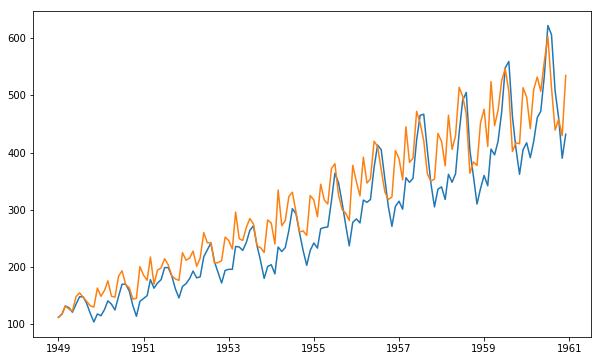

In [201]:
predicted_dataset=np.exp(predictions_arima_log)
plt.plot(indexed_dataset)
plt.plot(predicted_dataset)
plt.show()

C:\Users\Adarsh\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\Adarsh\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:1847: FutureWarning: TimeSeries is deprecated. Please use Series
  forecast = TimeSeries(forecast, index=self.data.predict_dates)


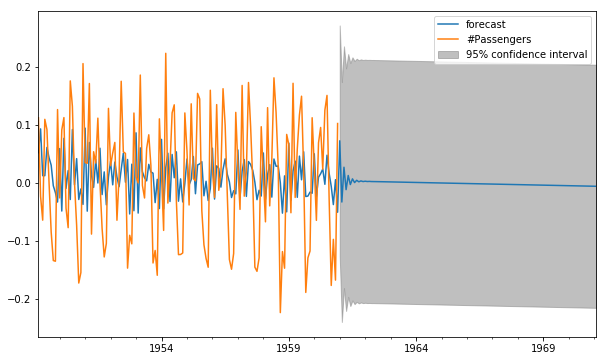

In [202]:
#If we wish to predict for next 10 years i.e. 120 months, we will add 120 rows to 144
results_ARIMA.plot_predict(1,264)


In [203]:
results_ARIMA.forecast(steps=120)

(array([ 7.25687280e-02, -3.28234173e-02,  2.70652344e-02, -1.15426410e-02,
         1.28603601e-02, -2.78660725e-03,  7.03692257e-03,  6.62855000e-04,
         4.58946365e-03,  1.96547806e-03,  3.50726620e-03,  2.39987930e-03,
         2.97720426e-03,  2.48315644e-03,  2.67043559e-03,  2.42443283e-03,
         2.45397063e-03,  2.30828163e-03,  2.27402607e-03,  2.16890572e-03,
         2.10885100e-03,  2.02013732e-03,  1.94964897e-03,  1.86757043e-03,
         1.79286254e-03,  1.71346737e-03,  1.63705303e-03,  1.55874306e-03,
         1.48163859e-03,  1.40376750e-03,  1.32638393e-03,  1.24869033e-03,
         1.17119389e-03,  1.09357207e-03,  1.01602998e-03,  9.38437187e-04,
         8.60876640e-04,  7.83295586e-04,  7.05727573e-04,  6.28151267e-04,
         5.50580235e-04,  4.73005848e-04,  3.95433595e-04,  3.17859985e-04,
         2.40287238e-04,  1.62713943e-04,  8.51409959e-05,  7.56782731e-06,
        -7.00052002e-05, -1.47578318e-04, -2.25151378e-04, -3.02724474e-04,
        -3.8